# Applying Classification

In this chapter we'll look at a few examples of applying classification.  We'll start by looking at A/B testing like we did for applying hypothesis testing.  Then we'll move onto an example with customer churn.  Then we'll look at unbalanced classification.  We'll end the chapter with an example of credit card fraud.  

## A/B Testing

Recall from the Applying Statistical Tests chapter we want to send an email about a towel sale.  We will have both a control and test group - one in which something about the email changed (test) and one in which the email stays the same as in the past (control).  We will use these two samples to set up an experiment.  Did changing the email effect things?

Last time we answered this question with hypothesis testing.  Now we will answer it with a classifier!

### Recall Set Up

In order to test this question, we can set up an experiment.  Here we will set up a randomized test group and a randomized control group.  

The test group will be sent an email, with slightly different copy, or possibly with a picture.  Some specific change will be made, in any event.

The control group will get the same email as last time.  This way, we can directly compare, as much as possible between the old email and the new one.  There are many things you typically need to control for, or account for in experimental design.  Some things to account for in this scenario are:

1) Age

2) Gender

3) Location

4) Time of Day

5) Time of Year

6) Approximate Disposable Income


## Simulating Some Data

In [4]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import random
import pandas as pd
import numpy as np

def generate_data(df, column, choices, size):
    """
    Generates categorical data given choices.
    
    Parameters:
    * df - pd.DataFrame: the data to add a column to
    * column - str: the column to generate
    * choices - list: the list of possible choices
    
    Returns:
    A dataframe with the newly generated column.
    """
    df[column] = [random.choice(choices)
                  for _ in range(size)]
    df = pd.concat([df, pd.get_dummies(df[column])], axis=1)
    df = df.drop(column, axis=1)
    return df

def converted_score(x):
    if x["male"] == 1:
        gender = 0.7
    elif x["female"] == 1:
        gender = 1.4
    if x["white"] == 1:
        race = 0.5
    elif x["black"] == 1:
        race = 1.4
    elif x["asian"] == 1:
        race = 2.8
    elif x["hispanic"] == 1:
        race = 3.7
    salary_alpha = gender * race
    age_alpha = gender + race
    return salary_alpha * x["salary"] + age_alpha * x["age"]

def decision_boundary(result):
    if result > 250000:
        return 1
    else:
        return 0
    
size = 5000
test_df = pd.DataFrame()
control_df = pd.DataFrame()
gender_choices = ["male", "female"]
race_choices = ["white", "black", "asian", "hispanic"]
test_salary_mean = 150000
test_salary_variance = 30000 
control_salary_mean = 55000
control_salary_variance = 2000

test_df = generate_data(test_df, "gender", gender_choices, size)
test_df = generate_data(test_df, "race", race_choices, size)
test_df["age"] = np.random.normal(50, 25, size=len(test_df))
test_df["age"] = test_df["age"].astype(int)
test_df["salary"] = np.random.normal(test_salary_mean, 
                                     test_salary_variance, 
                                     size=len(test_df))
test_df["salary"] = test_df["salary"].apply(lambda x: round(x, 2))

test_df["converted"] = test_df.apply(converted_score, axis=1)
test_df["converted"] = test_df["converted"].apply(decision_boundary)

control_df = generate_data(control_df, "gender", gender_choices, size)
control_df = generate_data(control_df, "race", race_choices, size)
control_df["age"] = np.random.normal(50, 25, size=len(control_df))
control_df["age"] = control_df["age"].astype(int)
control_df["salary"] = np.random.normal(control_salary_mean, 
                                        control_salary_variance, 
                                        size=len(control_df))
control_df["salary"] = control_df["salary"].apply(lambda x: round(x, 2))
control_df["converted"] = control_df.apply(converted_score, axis=1)
control_df["converted"] = control_df["converted"].apply(decision_boundary)

print(test_df["converted"].value_counts())
print(control_df["converted"].value_counts())

1    2822
0    2178
Name: converted, dtype: int64
0    4393
1     607
Name: converted, dtype: int64


Here's where things get different! The next step is now to model our test and control and see if the probability of conversion is higher or lower for our test and control sets.  If they are the same or similar then our change likely had little effect.  Of course you should verify this with multiple tests as well as cross validation if possible.

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       562
           1       0.96      1.00      0.98       688

    accuracy                           0.98      1250
   macro avg       0.98      0.97      0.98      1250
weighted avg       0.98      0.98      0.98      1250

ROC AUC 0.9733096085409252


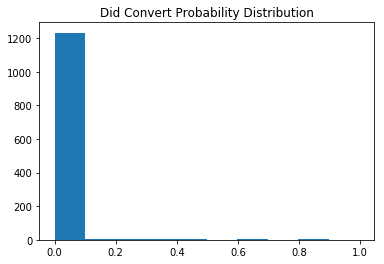

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

augmented_df = test_df.copy()
augmented_y = augmented_df["converted"]
cols = augmented_df.columns.tolist()
cols.remove("converted")
augmented_X = augmented_df[cols]

X_train, X_test, y_train, y_test = train_test_split(
    augmented_X, augmented_y
)
test_clf = LogisticRegression(
    max_iter=1000, class_weight="balanced", 
    C=100, penalty="l2", solver="liblinear"
)
test_clf.fit(X_train, y_train)
y_pred = test_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC", roc_auc_score(y_test, y_pred))
plt.hist(clf.predict_proba(X_test).T[1])
plt.title('Did Convert Probability Distribution')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1108
           1       1.00      1.00      1.00       142

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250

ROC AUC 1.0


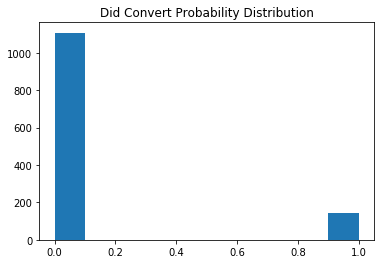

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

control_y = control_df["converted"]
cols = control_df.columns.tolist()
cols.remove("converted")
control_X = control_df[cols]

X_train, X_test, y_train, y_test = train_test_split(
    control_X, control_y
)
control_clf = LogisticRegression(
    max_iter=1000, class_weight="balanced", 
    C=100, penalty="l2", solver="liblinear"
)
control_clf.fit(X_train, y_train)
y_pred = control_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC", roc_auc_score(y_test, y_pred))
plt.hist(clf.predict_proba(X_test).T[1])
plt.title('Did Convert Probability Distribution')
plt.show()

## Interpretation

So we record all of the standard metrics to make sure our model explains what we are seeing well.  Then we look at the probability distributions for convert (y=1) and not convert (y=0).  If

$$ P(converted | y=1) \nsim P(converted | y=0)$$ 

then we can say our trial produced a meaningful result and we can say that our test data indeed changed something.

Note: this is a worked example!  If this was the real world and you saw those accuracy measures, you ought to be very, very skeptical.  Especially the second set.

Let's look at the specifics of our example:

For test:

* about 500 converted with a high probability and 450 converted with a very low probability.

For control:

* about 1200 people did not convert with a high probability and around 200 converted with a high probability.

Clearly the test group had a different experience!  But why?  Let's dig further into the data by looking at `test_df` and `control_df`:


In [10]:
test_df.describe()

,female,male,asian,black,hispanic,white,age,salary,converted
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.503600,0.496400,0.250800,0.258800,0.247800,0.242600,50.339400,150040.746312,0.564400
std,0.500037,0.500037,0.433517,0.438019,0.431778,0.428698,24.645724,30019.400205,0.495885
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.000000,41819.190000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,130438.922500,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,150082.165000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,67.000000,170778.290000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,143.000000,256016.380000,1.000000


In [11]:
control_df.describe()

,female,male,asian,black,hispanic,white,age,salary,converted
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.504400,0.495600,0.264600,0.243800,0.243200,0.248400,49.159800,54987.455054,0.121400
std,0.500031,0.500031,0.441164,0.429416,0.429058,0.432128,24.594407,1986.156938,0.326624
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-40.000000,48168.270000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,53631.270000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,55009.735000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,66.000000,56297.607500,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,145.000000,63514.950000,1.000000


We can see a huge difference in salary!  Let's look at how big the difference is on average:

In [12]:
test_df["salary"].mean() - control_df["salary"].mean()

95053.29125800001

Around 95K!  That's a huge difference in standard of living.  Let's go back to our model and look at our coefficients:

In [18]:
for index, coef in enumerate(test_clf.coef_[0]):
    print(test_df.columns[index], coef)

female 0.9292687935837641
male -4.103078995398313
asian 2.6485300549834054
black -2.6993728240235115
hispanic 4.453509716475326
white -7.576477149249771
age -0.0009181427593822856
salary 4.08325526503341e-05


In [19]:
for index, coef in enumerate(control_clf.coef_[0]):
    print(control_df.columns[index], coef)

female 6.9140512773516924
male -7.395307616549721
asian -3.8570837201125263
black -3.806284792620383
hispanic 11.029417213298009
white -3.847305039763138
age -0.0029246918380587596
salary -0.00018044270948364995


The big thing to pay attention to here is effect size - how the size of the variable and it's weight changes the decision or result of the model.

The effect size of salary may _seem_ small based on these coefficients, but I assure you it's not.  Recall, that for logistic regression the equation is:

$$ \theta_{i}x_{i} $$

That means we need to consider the _multiplication_ of these two variables.  Let's just look at the average salary for the two groups to get a sense of effect size:

For test:

$$ \theta * mean(salary) = 6.126546673480162 $$

That is, `4.08325526503341e-05 * 150040.746312 = 6.126546673480162`.

Given that effect size is exponentiated by the base, in this case $e$, the natural number.  We have, an increase in salary by 1 dollar leading to an increase in P(Y=1) of:

$$ e^{6.126546673480162} = 457.85231394605876 $$

Which is _a lot_.  Especially given the effect size of the other coefficients.

I'll leave as an exercise carrying this out for the other model.  But let's just say the effect size is similar.

What that implies should be obvious, how much you make matters a ton!  So can we tell if the change actually meant anything?  Nope!  We have no idea.  We should construct this problem again, controlling explicitly for income in order to get a fair test.

## Example Two - Customer Churn

The next typical data science problem we are going to tackle is customer churn!  This is huge for product development, sales cycles and just keeping a business afloat.  If you know and can predict how much your customers are going to churn you can reliably forecast how much revenue to expect per quarter.  Which is basically essential to any and all businesses.  

Since customer churn is so important, it's worth noting that there is more to churn than just what's in your model.  It can help drive decisions, but it's very important to include domain experts in churn conversations.  This means designers, UX and design folks, sales folks, executives and other stakeholders.  All of these folks matter.  For one, your model may not take into account critical variables.  For another thing, you may not be measuring enough.  A good model doesn't replace people, it helps inform a conversation and aids in decision making.

Let's start with some context for what Customer Churn is and go through some possible definitions:

Customer churn, loosely, is the number of customers that will stop paying for your service over a specified period of time.

Definition one:

$$ \frac{customers \space lost \space during \space fixed \space period}{total \space customers \space at \space the \space start \space of \space the \space fixed \space period} $$

Notice, this does not take into account the total number of customers gained.  Say for instance you started out with 100 customers, then you gained 1 million over the course of the fixed period, say a month, and then 15 thousand churned.  Your churn for the month would be:

$$ \frac{15000}{100} = 150 \% $$

If 150% of your customers churn, you might think your business is _not_ doing great.  But you gained like a million new customers over the period!  So in actuality, this is very good news, _overall_.  If you don't get a ton of new customers, this might be a good enough metric.

Definition two:

$$ \frac{Churn}{Customers_{1} + Customers_{n} / 2} $$

Where:

$ Customer_{1} $ := number of customers at the start of the month

$ Customer_{n} $ := number of customers at the end of the month

So over the same window we get:

$$ \frac{15000}{(100 + 1000000)/2} = 0.029\% $$

Which sounds much more reasonable, and accurate.

Definition three:

$$ \frac{Churn}{\frac{1}{n} \displaystyle \sum_{i=1}^{n} Customer_{i}} $$

Here we take the average of the customer count over the period of interest, this further normalizes the churn.

## Modeling Churn

Once you have a good measure of Churn, that works for you, the next step is to understand your Churn number.  For this we'll create a model of the world that incorpates other data to understand when and more importantly why customers churn.

For this example we will be making use of this dataset from kaggle:

https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers

To get this part of the notebook to run, you'll need to download and unzip the data locally (a pain I know).



In [90]:
import pandas as pd

df = pd.read_csv("Churn_Modelling.csv")
df.drop("RowNumber", inplace=True, axis=1)
df.drop("CustomerId", inplace=True, axis=1)
df["Churn"] = df["Exited"] 
df.drop("Exited", inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Churn              10000 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


We drop the `RowNumber` and the `CustomerId` since they won't be useful for understanding why our customers churn or stay.  Some of the other information may be useful.  First let's look at `Gender`:

In [62]:
summary["Churn %"] = df.pivot_table(values="Churn", index='Gender', aggfunc=np.mean)
summary["Churn Total"] = df.pivot_table(values="Churn", index="Gender", aggfunc=np.sum)
summary.drop("Churn", axis=1)

,Churn %,Churn Total
Gender,,
Female,0.250715,1139
Male,0.164559,898


It seems pretty clear that `Gender` is going to matter, and that `Churn` is going to be higher for women than men.

Now let's see if this is True for all countries under consideration:

In [69]:
print(df["Geography"].unique())
summary = df.pivot_table(values="Churn", index=['Gender'], columns=["Geography"], aggfunc=np.mean)
summary

['France' 'Spain' 'Germany']


Geography,France,Germany,Spain
Gender,,,
Female,0.203450,0.375524,0.212121
Male,0.127134,0.278116,0.131124


It appears churn rates are higher across the board for women over men, however churn rates do vary from country to country:

In [70]:
print(df["Geography"].unique())
summary = df.pivot_table(values="Churn", index=['Gender'], columns=["Geography"], aggfunc=np.sum)
summary

['France' 'Spain' 'Germany']


Geography,France,Germany,Spain
Gender,,,
Female,460,448,231
Male,350,366,182


This is probably a function of population size.  However this means explicitly controlling for `Geography` is probably important, because otherwise we may lose a confounding effect, which would lower the generalizability of our analysis.

Next let's look at the effect of age on Churn.  For this we should first run the test for independence followed by a test for correlation.  Recall, we will use Kruskal-Wallis for independence and point bi serial correlation for correlation:

In [71]:
from scipy import stats

print(stats.kruskal(df["Age"], df["Churn"]))
print(stats.pointbiserialr(df["Age"], df["Churn"]))

KruskalResult(statistic=16030.329492796818, pvalue=0.0)
PointbiserialrResult(correlation=0.28532303783506824, pvalue=1.2399313093495365e-186)


With a pvalue of zero we reject the null hypothesis that the two variables are independent.  Additionally, we see a pvalue of close to zero for point bi serial correlation, therefore we reject the null hypothesis of no correlation.  So `Age` is a variable of interest.  We can also confirm this with mutual information:

In [76]:
from sklearn import feature_selection
feature_selection.mutual_info_regression(df["Age"].values.reshape(-1, 1), df["Churn"])

array([0.05644672])

If you haven't read An Introduction to Information Theory yet, the important things to note are when mutual information is 1, the variables are perfectly dependent.  When it's zero they are the same.  So there is some weak information sharing between `Age` and `Churn`.

We can actually go through the rest of the variables to see which ones are likely useful for predicting churn with mutual information:

In [81]:
features = [column for column in df.columns if df[column].dtype != "object"]
features.remove("Churn")
X = df[features]
y = df["Churn"]
ranks = feature_selection.mutual_info_regression(X, y)
rankings = []
for index, feature in enumerate(features):
    rankings.append((feature, ranks[index]))
sorted(rankings, key=lambda t: t[1], reverse=True)

[('NumOfProducts', 0.06494083770576875),
 ('Age', 0.06393611325910786),
 ('Balance', 0.016154281264732617),
 ('IsActiveMember', 0.011668822982624505),
 ('CreditScore', 0.00460938156808588),
 ('EstimatedSalary', 0.0027089277988778804),
 ('Tenure', 0.0024970855875752207),
 ('HasCrCard', 0.0016902194714116803)]

So we see that `NumOfProducts` is the most important and `HasCrCard` is the least important.  Or rather carries the least information about probability of churning.  This is possibly because most people have a credit card these days.

Next let's kick out any variables that don't likely matter.  In this case, we can probably safely remove `HasCrCard`:

In [91]:
df.drop("HasCrCard", axis=1, inplace=True)

Let's also drop `Surname`, since any information it gives us is probably spurious:

In [92]:
df.drop("Surname", axis=1, inplace=True)

Now we are almost ready to fit our model!  Let's first get our categorical variables ready:

In [93]:
for column in df.columns:
    if df[column].dtype == "object":
        df = pd.concat([df, pd.get_dummies(df[column])], axis=1)
        df = df.drop(column, axis=1)


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, log_loss

y = df["Churn"]
cols = df.columns.tolist()
cols.remove("Churn")
X = df[cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
logit = LogisticRegression(
    C=1, penalty="l2", max_iter=1000, 
    class_weight="balanced"
)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.65      0.74      1944
           1       0.35      0.66      0.46       556

    accuracy                           0.65      2500
   macro avg       0.61      0.66      0.60      2500
weighted avg       0.76      0.65      0.68      2500

0.6562953341030878
11.978264824417066


Since our model doesn't do great, let's try toying around a little bit:

In [97]:
for index, col in enumerate(cols):
    print(col, logit.coef_[0][index])

CreditScore -0.0031436478957918785
Age 0.05898746159233117
Tenure -0.08679665322930301
Balance 3.905155260992167e-06
NumOfProducts -0.039819154004494525
IsActiveMember -0.07847513122067634
EstimatedSalary -9.223377167585139e-07
France -0.04440259570810289
Germany 0.05012964004326264
Spain -0.022347366299728076
Female 0.04293418313482472
Male -0.059554505098413556


None of the variables really jump out as the issue.  You might think that `EstimatedSalary` and `Balance` are the issue, but both of them are much larger than the rest, so the size of their coefficients make sense in context of their scale.

In [139]:
logit_linear = LogisticRegression(
    solver="liblinear",
    C=1, penalty="l1", max_iter=10000, 
    class_weight="balanced"
)
logit_linear.fit(X_train, y_train)
y_pred = logit_linear.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1944
           1       0.42      0.70      0.53       556

    accuracy                           0.72      2500
   macro avg       0.66      0.71      0.66      2500
weighted avg       0.79      0.72      0.74      2500

0.7129870177931729
9.7262918260128


We don't do "great", but not too bad!  We are now in a place to interpret our results:

In [140]:
for index, col in enumerate(cols):
    print(col, logit_linear.coef_[0][index])

CreditScore -0.0006180222871635596
Age 0.0782462365221455
Tenure -0.006832107433490348
Balance 2.6100726865106033e-06
NumOfProducts -0.125957377561036
IsActiveMember -0.8492739668684903
EstimatedSalary 1.2544822574956195e-07
France -0.807417662931865
Germany 0.0
Spain -0.8244401538543713
Female -0.34300710576221705
Male -0.9037524239656831


This isn't super telling because of the order of magnitude issue, so let's multiply by our average to at least get a (possibly skewed) sense of scale:

In [142]:
features = []
for index, col in enumerate(cols):
    features.append((col, 
                     logit_linear.coef_[0][index] * df[col].mean()
                    ))
features = sorted(features, key=lambda t:t[1], reverse=True)

for feature in features:
    print(feature)

('Age', 3.0454843686676427)
('Balance', 0.19963373053408276)
('EstimatedSalary', 0.012556143007919497)
('Germany', 0.0)
('Tenure', -0.03424798814260042)
('Female', -0.1558281281477752)
('NumOfProducts', -0.1927399791438973)
('Spain', -0.20421382610972777)
('CreditScore', -0.40204129684176587)
('France', -0.40483921619403707)
('IsActiveMember', -0.4374610203339594)
('Male', -0.49317769775807324)


Looks like `Age`, `Balance` and `EstimatedSalary` are the most important features on the positive contribution to `Churn`.  This is actually really, really bad.  That means that our most valuable customers - those with the highest bank accounts are most likely to churn!  Additionally, looks like there is a negative relationship with `CreditScore` which is a good thing, because that means those who can pay more regularly are more likely to stay customers.  Also, there is a negative relationship with `IsActiveMember`, which makes sense.  This means that those who use the service the least are most likely to churn.  So if someone with a large estimated salary isn't active on the platform, constructing an intervention to keep them around is probably a good idea!

Also, it looks like targeting men is a safer bet than targetting women.  But it's probably a good idea to try to change that because you don't want to miss out on 50% on the population!  

Let's try rerunning the model with just the most important features:

In [143]:
y = df["Churn"]
cols = ["Male", "IsActiveMember", "CreditScore", "France", "Age", "Balance", "EstimatedSalary"]
X = df[cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
logit = LogisticRegression(
    C=1, penalty="l2", max_iter=1000, 
    class_weight="balanced"
)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.65      0.75      1944
           1       0.36      0.68      0.47       556

    accuracy                           0.66      2500
   macro avg       0.62      0.67      0.61      2500
weighted avg       0.76      0.66      0.69      2500

0.6661892708055777
11.757214416616833


Looks there was a little bit of shrinkage, but not that much!  Which means this is probably an okay model of what's happening with `Churn`.  That said probably a good idea to watch the demographic and geographic stuff even if it's not super explanatory because it might be subject to change / is important to keep a watch of!

## Anamoly Detection

It's time for to deal with the problem that is the bane of every data scientists existance - anamoly detection.  If you've never dealt with one of these before, don't worry, at some point you will.  These things come up _a lot_ in information extraction from text.  But they also come up generally in a bunch of places.  Normal models won't work, no matter what you try.  And worse then that, you might not even realize you are dealing with an anamoly detection problem until it's far too late.  As in, you've gone to production and the sample data you saw for training and testing was _far_ too curated.  

Anamoly detection, is basically when your data falls into a class around 90-95% and about 10% or less the rest of the time.  It may be the case that this happens because, like I stated above the data you saw when you were developing the model was _not_ representative.  This can get _especially_ bad with multiclass classification where multiple classes are relatively rare in production.  You might say, these cases are easy!  Just ignore the rare classes, no point in dredging the swamp for the extra little bit of value!  And honestly, that might be a good answer, _sometimes_.  But you won't always get lucky with who you are employed by, who your boss is, or what they care about.

Or in some cases, it may be by the design of the problem.  Of course, the first scenario is _far_ worse, so we will focus on the second case, where there is an anamolous class, by design.  We will also focus on the case of binary classification, because multiclass classification, is frankly speaking, just too hard.

### Problem Set up - Credit Card Fraud Detection

The problem of fraud is fairly straight forward - someone uses your card for a purchase that's "weird" and the credit card company tells you about it.  Of course, this case isn't going to happen often (we hope).  So it's the minority class by _a lot_.  We might not have many examples per customer of this occurring.  However, we may have 'enough' examples over the course of many customers.  This of course, means there will be a lot more cases of transactions where this _didn't_ happen, which can be tough, because your classifier will just learn the majority class.  This also may not be reflected in your metrics since precision, recall and f1 score will all look _great_.  However, really what this means is, they are great for the majority class, not the minority class.



References:
* https://towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266
* https://blog.markgrowth.com/eliminating-churn-is-growth-hacking-2-0-47a380194a06
* https://towardsdatascience.com/churn-prediction-3a4a36c2129a
* https://www.profitwell.com/blog/the-complete-saas-guide-to-calculating-churn-rate-and-keeping-it-simple